In [2]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import os
import sys
sys.path.insert(0, 'functions/')
from tools import *
from h5_tools import *
from fitting_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
# import pandas as pd
import glob

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.5", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

In [4]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [5]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [6]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

# Brownian motion $q$-dependence

In [7]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


In [8]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')

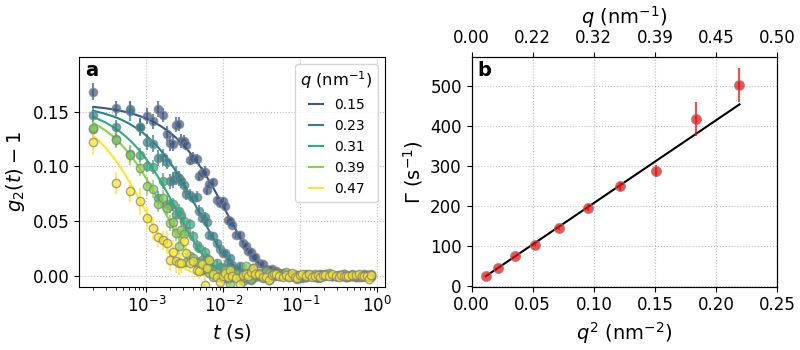

In [9]:
f, (a1,a3) = plt.subplots(1,2, figsize=(8,3.5), constrained_layout=True)
ax2 = a3.twiny()


col = plt.cm.viridis(np.linspace(0,1,len(qv)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 2, len(qv), 1

i = 4
taus, dtaus = [], []

for q in range(qv_min, qv_max, qstep):
    base = np.average(g2s[i,q,-15:])
    popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
    taus.append(popt[1])
    dtaus.append(perr[1])
    
    if q%2 == 1:
        a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[q], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
        a1.plot(xc, curve, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')

qs = qv[qv_min:qv_max:qstep]
taus, dtaus = np.asarray(taus), np.asarray(dtaus)
cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])

a3.plot(xc, curve, c='k')#, label=f'{Ds[0,i]:.2e}')
a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c='r', ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'$q$ (nm$^{-1}$)', fontsize=10, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.2)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
a3.set_xticks(np.arange(0,0.26,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.26,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.26,0.05))])
ax2.set_xlabel('$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)

# plt.savefig('../06-figs/g2s_q-dep.png', dpi=300)

# Fig 1 - g2s

In [10]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


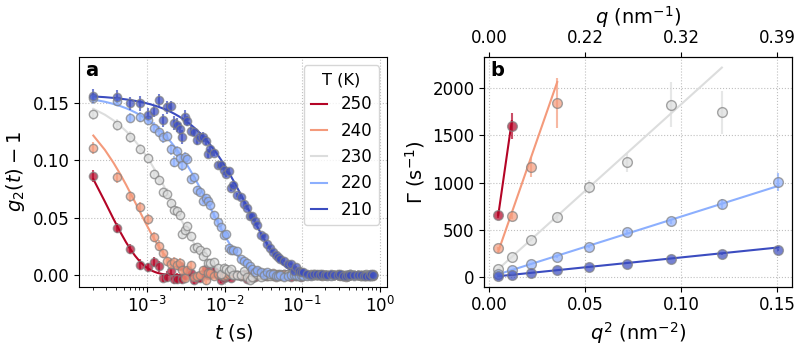

In [11]:
f, (a1,a3) = plt.subplots(1,2, figsize=(8,3.5), constrained_layout=True)
ax2 = a3.twiny()

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            # a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=1, label=f'{T[i]:.0f}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    # a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'T (K)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
# a3.set_xscale('log')
# a3.set_yscale('log')
a3.set_xticks(np.arange(0,0.16,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.16,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.16,0.05))])
ax2.set_xlabel('$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)

# plt.savefig('../06-figs/g2s.png', dpi=300)

# Fig bonus - $g_2$ concentrations

In [12]:
# 240 K
runnames_conc = ['ferritin_conc_gly_50_6', 'ferritin_conc100_gly_50_1', 'ferritin_conc120_gly_50_1']
datasetnumbers_conc = [3,9,7] # 240 K

In [13]:
T_conc, Tr_conc = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers_conc, runnames_conc)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr_conc.append(info['transmission (%)'])
        T_conc.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc100_gly_50_1_0009.h5 
File exists:  True 

measurement folder   ferritin_conc100_gly_50_1_0009
Temperature, K       240.0
transmission (%)     nan
Absorbers 80um       nan
Absorbers 100um      nan
Short comment        nan
comment              nan
Exposure time (s)    nan
number of frames     nan
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0007.h5 
File exists:  True 

measurement folder   ferritin_conc120_gly_50_1_0007
Temperature, K       240.0
transm

In [14]:
filename = h5dir + f'{runnames_conc[0]}_{datasetnumbers_conc[0]:04d}.h5'
len_g2 = len(load_data(filename, 'xpcs/g2s/delay'))
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s_conc = np.empty(shape=(len(datasetnumbers_conc),len(qv),len_g2))
dg2s_conc = np.empty(shape=(len(datasetnumbers_conc),len(qv),len_g2))
delays_conc = np.empty(shape=(len(datasetnumbers_conc),len_g2))

for i, (datasetnumber,runname) in enumerate(zip(datasetnumbers_conc, runnames_conc)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    print(filename, os.path.isfile(filename))
    
    g2s_conc[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s_conc[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays_conc[i,:] = load_data(filename, 'xpcs/g2s/delay')


/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 True
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc100_gly_50_1_0009.h5 True
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0007.h5 True


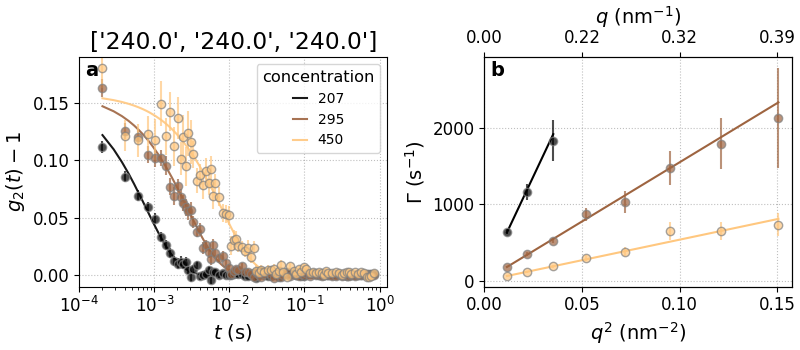

In [15]:
f, (a1,a3) = plt.subplots(1,2, figsize=(8,3.5), constrained_layout=True)
ax2 = a3.twiny()

col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers_conc)))
qv_sel = 2
tol = 1e-3

qv_min, qv_max, qstep = 2, len(qv)-2, 1

concs_l = ['c1', 'c2', 'c3']
concs_l = ['207', '295', '450']

for i in range(len(datasetnumbers_conc)):
    taus, dtaus = [], []

    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays_conc[i,:], g2s_conc[i,q,:]-base, sigma=dg2s_conc[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            a1.errorbar(delays_conc[i,:], g2s_conc[i,q,:]-base, dg2s_conc[i,q,:], c=col[i],ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{concs_l[i]}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)

    # cond = (taus>dtaus) & (dtaus!=0)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)

a1.legend(title='concentration', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.set_xlim(1e-4,None)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)
a1.set_title(T_conc)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
a3.set_xticks(np.arange(0,0.16,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.16,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.16,0.05))])
ax2.set_xlabel('$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)
# plt.savefig('../06-figs/g2s_concs.png', dpi=300)

# Fig 2 - diffusion coefficient

### Arrhenius

In [16]:
def get_diff_coeff_library(filename='../03-source/diffusion_coefficient'):
    """Return dataframe with diffusion coefficients from the experimental data
    """
    df = pd.read_pickle(filename)
    df['temperature'] = df['temperature'].replace(243, 240)
    df['transmission'] = df['transmission'].str.replace('%', '')
    df['transmission'] = df['transmission'].str.replace('nan', '100')
    df['transmission'] = df['transmission'].str.replace('~', '')
    df['transmission'] = df['transmission'].astype(float)
    
    return df

In [17]:
df2 = get_diff_coeff_library()

In [18]:
# load dls data
# DLS = load_npz_data('../03-source/DLS_diff_coeff.npz') # D in m^2/s, T in K
DLS = load_npz_data('../03-source/dls_diluted.npz') # D in m^2/s, T in K
DLS['D'] = DLS['D']*1e12
DLS['dD'] = DLS['dD']*1e12

SU13 = load_npz_data('../03-source/dls_su13.npz') # D in m^2/s, T in K
SU13['D'] = SU13['D']*1e12

SU13_3 = load_npz_data('../03-source/dls_su13_3.npz') # D in nm^2/us, T in K
# SU13_3['D'] = SU13_3['D']*1e12

In [19]:
D_c1 = df2[(df2['c']=='c1') & (df2['transmission']==100)].sort_values(by='temperature')
D_c2 = df2[(df2['c']=='c2') & (df2['transmission']==100)].sort_values(by='temperature')
D_c3 = df2[(df2['c']=='c3') & (df2['transmission']==100)].sort_values(by='temperature')

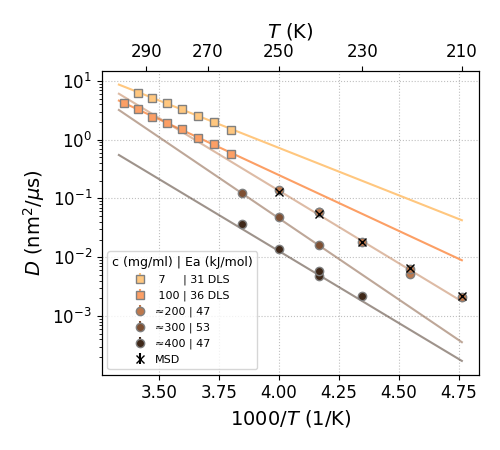

In [44]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
ax2 = ax.twiny()

scale = 1e3
cols = plt.cm.copper_r(np.linspace(0,1,6))

Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
new_T = np.linspace(210,300,100)

# -- first plot
# DLS
# a1.plot(scale/DLS['T'], 1*np.exp(-3.6e3/DLS['T']), ls='--', c='k')
popt2,xc2,curve2,perr2 = fit(arrhenius, DLS['T'],  DLS['D'], sigma=DLS['dD'], p0=[1e6, -3e3])
Ea2, dEa2 = popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na
# ax.plot(scale/xc2, curve2, ls='-', c='C0', label=f'Ea = {Ea2:.0f} ± {dEa2:.0f} kJ/mol')
ax.plot(scale/new_T, arrhenius(new_T, *popt2), ls='-', c=cols[0])#,label=f'7 mg/ml - DLS')# label=f'DLS: Ea={-Ea2:.0f} kJ/mol')# ± {dEa2:.0f} kJ/mol')
ax.errorbar(scale/DLS['T'], DLS['D'], DLS['dD'], c=cols[0], ls='', marker='s', mec='gray',label=f' 7     | {-Ea2:.0f} DLS') # label='DLS dilute',
# print(popt2)

# new dls SU13_3
popt2,xc2,curve2,perr2 = fit(arrhenius, SU13_3['T'],  SU13_3['D'], sigma=SU13_3['dD'], p0=[1e6, -3e3])
Ea2, dEa2 = popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na
ax.plot(scale/new_T, arrhenius(new_T, *popt2), ls='-', c=cols[1])#,label=f'7 mg/ml - DLS')# label=f'DLS: Ea={-Ea2:.0f} kJ/mol')# ± {dEa2:.0f} kJ/mol')
ax.errorbar(scale/SU13_3['T'], SU13_3['D'], SU13_3['dD'], c=cols[1], ls='', marker='s', mec='gray',label=f' 100 | {-Ea2:.0f} DLS') # SU13_3



# 3 concentrations with arrhenius fit
# labs = ['c1', 'c2', 'c3']
labs = ['≈200', '≈300', '≈400']
# labs = ['≈100', '≈200', '≈350'] # very scheptical about this
for i, db in enumerate([D_c1,D_c2, D_c3]):
    # if i != 1:
    tem = np.array(db['temperature'])
    dif = db['D']
    ddif = db['dD']
    popt,xc,curve,perr = fit(arrhenius, tem, dif, sigma=ddif, p0=[15e4, -3e3])
    Ea, dEa = popt[1] * Kbb / 1e3 * Na, perr[1] * Kbb / 1e3 * Na

    new_T = np.linspace(210,300,100)
    # ax.plot(scale/xc, curve, ls='-', c='C3',label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')
    ax.plot(scale/new_T, arrhenius(new_T, *popt), ls='-', c=cols[i+2], alpha=0.5, )#label=f'{labs[i]} mg/ml')#label=f'{labs[i]}, Ea={-Ea:.0f} kJ/mol')
    ax.errorbar(scale/db['temperature'],  db['D'], db['dD'], c=cols[i+2], ls='', marker='o', mec='gray',label=f'{labs[i]} | {-Ea:.0f}')#, label=labs[i])

# -- MSD
ax.errorbar(scale/T_msd, D_msd[:,0], D_msd[:,1], marker='x', ls='', c='k', label='MSD')

# -- plot setting
ax.set_xlabel(f'${scale:.0f}/T$ (1/K)')
ax.set_ylabel('$D$ (nm$^{{2}}$/${{\mu}}$s)')
ax.legend(fontsize=8, handlelength=1, loc='lower left', title='c (mg/ml) | Ea (kJ/mol)', title_fontsize=9) #, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(270,210)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/np.arange(210,300,20))
ax2.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax2.set_xlabel('$T$ (K)', fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
# plt.savefig('../06-figs/diff_coeff_arr2.png', dpi=900)

**Normalized**

$ D = \frac{k_B T}{6\pi\eta R_h} $

In [21]:
R = 7.3e-9 # nm
eta = Kbb*T / (6*np.pi*Ds[0,:]*R)
eta[T==250]

array([1.77252932e-13])

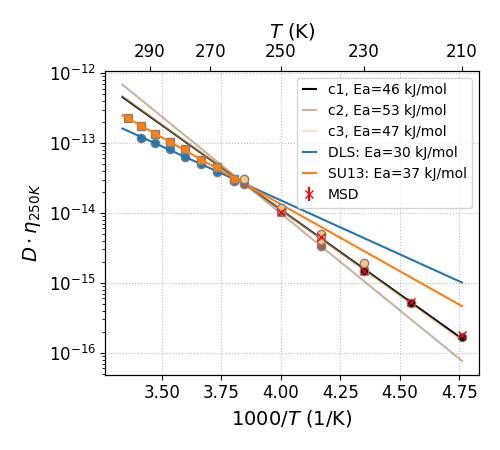

In [52]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
ax2 = ax.twiny()
cols = plt.cm.copper(np.linspace(0,1,3))
# constants
Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
scale = 1e3
R = 7.3e-9 # nm
T_sel = 260

# -- arrhenius fit xpcs
popt,xc,curve,perr = fit(arrhenius, T, Ds[0,:], sigma=Ds[1,:], p0=[15e4, -3e3])
Ea, dEa = popt[1] * Kbb / 1e3 * Na, perr[1] * Kbb / 1e3 * Na
new_T = np.linspace(210,300,100)
# ax.plot(scale/xc, curve, ls='-', c='C3',label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')

y_fit = arrhenius(new_T, *popt)
eta = Kbb*new_T / (6*np.pi*y_fit*R)
norm_eta = eta[new_T==T_sel]
norm_etas = [norm_eta]

ax.errorbar(scale/T, Ds[0,:]*norm_eta, Ds[1,:]*norm_eta, ls='', marker='o', mec='gray', c=cols[0])#, label='c1')
ax.plot(scale/new_T, y_fit*norm_eta, ls='-', c=cols[0],label=f'c1, Ea={-Ea:.0f} kJ/mol')#f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')

# other 2 concentrations with arrhenius fit
labs = ['c2', 'c3']
for i, db in enumerate([D_c2, D_c3]):
    
    tem = np.array(db['temperature'])
    dif = db['D']
    ddif = db['dD']
    popt,xc,curve,perr = fit(arrhenius, tem, dif, sigma=ddif, p0=[15e4, -3e3])
    Ea, dEa = popt[1] * Kbb / 1e3 * Na, perr[1] * Kbb / 1e3 * Na

    y_fit = arrhenius(new_T, *popt)
    eta = Kbb*new_T / (6*np.pi*y_fit*R)
    norm_eta = eta[new_T==T_sel]
    norm_etas.append(norm_eta)
    # ax.plot(scale/xc, curve, ls='-', c='C3',label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')
    ax.plot(scale/new_T, y_fit*norm_eta, ls='-', c=cols[i+1], alpha=0.5, label=f'{labs[i]}, Ea={-Ea:.0f} kJ/mol')#± {dEa:.0f} kJ/mol')
    ax.errorbar(scale/db['temperature'],  db['D']*norm_eta, db['dD']*norm_eta, c=cols[i+1], ls='', marker='o', mec='gray')#, label=labs[i])


# -- DLS only fit
# a1.plot(scale/DLS['T'], 1*np.exp(-3.6e3/DLS['T']), ls='--', c='k')
popt2,xc2,curve2,perr2 = fit(arrhenius, DLS['T'],  DLS['D'], p0=[1e6, -3e3])

Ea2, dEa2 = popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na

y_fit = arrhenius(new_T, *popt2)
eta = Kbb*new_T / (6*np.pi*y_fit*R)
norm_eta = eta[new_T==T_sel]
norm_etas.append(norm_eta)
ax.plot(scale/DLS['T'], DLS['D']*norm_eta, c='C0', ls='', marker='o', mec='gray',) # label='DLS dilute',
# ax.plot(scale/xc2, curve2, ls='-', c='C0', label=f'Ea = {Ea2:.0f} ± {dEa2:.0f} kJ/mol')
ax.plot(scale/new_T, y_fit*norm_eta, ls='-', c='C0',label=f'DLS: Ea={-Ea2:.0f} kJ/mol')# ± {dEa2:.0f} kJ/mol')

# -- new dls SU13
popt2,xc2,curve2,perr2 = fit(arrhenius, SU13_3['T'],  SU13_3['D'], p0=[1e6, -3e3])
Ea2, dEa2 = popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na

y_fit = arrhenius(new_T, *popt2)
eta = Kbb*new_T / (6*np.pi*y_fit*R)
norm_eta = eta[new_T==T_sel]
norm_etas.append(norm_eta)

ax.plot(scale/SU13_3['T'], SU13_3['D']*norm_eta, c='C1', ls='', marker='s', mec='gray')#,label=f'SU13 - DLS') # label='DLS dilute',
ax.plot(scale/new_T, arrhenius(new_T, *popt2)*norm_eta, ls='-', c='C1', label=f'SU13: Ea={-Ea2:.0f} kJ/mol')#,label=f'7 mg/ml - DLS')# label=f'DLS: Ea={-Ea2:.0f} kJ/mol')# ± {dEa2:.0f} kJ/mol')

# -- MSD
ax.errorbar(scale/T_msd, D_msd[:,0]*norm_etas[0], D_msd[:,1]*norm_etas[0], marker='x', ls='', c='r', label='MSD')


# -- plot settings
ax.set_xlabel(f'${scale:.0f}/T$ (1/K)')
ax.set_ylabel('$D\cdot\eta_{250 K}$')
ax.legend(fontsize=10, handlelength=1)#, bbox_to_anchor=[1,1])
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(270,210)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/np.arange(210,300,20))
ax2.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax2.set_xlabel('$T$ (K)', fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../06-figs/diff_coeff_arr2.png', dpi=300)

In [23]:
#SU13_3
# Ds_all = np.concatenate([DLS['D']*norm_etas[-1], D_c1['D'].values*norm_etas[0], D_c2['D'].values*norm_etas[1], D_c3['D'].values*norm_etas[2]], axis=0)
Ds_all = np.concatenate([DLS['D']*norm_etas[-2], SU13_3['D']*norm_etas[-1], D_c1['D'].values*norm_etas[0], D_c2['D'].values*norm_etas[1], D_c3['D'].values*norm_etas[2]], axis=0)
# Ds_all = np.concatenate([SU13_3['D']*norm_etas[-1], D_c1['D'].values*norm_etas[0], D_c2['D'].values*norm_etas[1], D_c3['D'].values*norm_etas[2]], axis=0)
# dDs_all = np.concatenate([DLS['dD'], D_c1['dD'].values*norm_etas[0], D_c2['dD'].values*norm_etas[1], D_c3['dD'].values*norm_etas[2]], axis=0)
dDs_all = np.concatenate([DLS['dD']*norm_etas[-2], SU13_3['dD'], D_c1['dD'].values*norm_etas[0], D_c2['dD'].values*norm_etas[1], D_c3['dD'].values*norm_etas[2]], axis=0)
# dDs_all = np.concatenate([SU13_3['dD'], D_c1['dD'].values*norm_etas[0], D_c2['dD'].values*norm_etas[1], D_c3['dD'].values*norm_etas[2]], axis=0)
# Ts_all = np.concatenate([DLS['T'], D_c1['temperature'].values, D_c2['temperature'].values, D_c3['temperature'].values], axis=0)
Ts_all = np.concatenate([DLS['T'], SU13_3['T'], D_c1['temperature'].values, D_c2['temperature'].values, D_c3['temperature'].values], axis=0)

In [24]:
from scipy import optimize
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, scale/Ts_all, Ds_all, sigma=dDs_all)
xd = np.linspace(scale/Ts_all[-1], scale/Ts_all[0], 100)
# plt.plot(x, y, "o")
ax.plot(xd, piecewise_linear(xd, *p), c='k')

/cfs/home/mabi3848/id10-ferritin-2022/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [25]:
import pwlf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-4.0476794  -5.61371431]


Text(0.7, 0.7, 'XPCS')

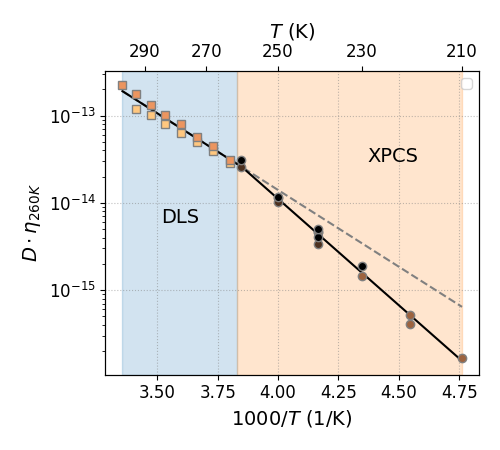

In [26]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
ax2 = ax.twiny()
cols = plt.cm.copper(np.linspace(0,1,3))
cols = plt.cm.copper_r(np.linspace(0,1,5))
# constants
Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
scale = 1e3
T_sel = 260

my_pwlf = pwlf.PiecewiseLinFit(scale/Ts_all, np.log(Ds_all))#, disp_res=True)
breaks = my_pwlf.fit(2)
print(my_pwlf.slopes)

# high T fit
x_hat = np.linspace((scale/Ts_all).min(), (scale/Ts_all).max(), 100)
y_hat2 = x_hat*my_pwlf.slopes[0] + my_pwlf.intercepts[0] #my_pwlf.predict(x_hat)
ax.plot(x_hat, np.exp(y_hat2),ls='--', c='gray')

# low T fit
# y_hat3 = x_hat*my_pwlf.slopes[1] + my_pwlf.intercepts[1] #my_pwlf.predict(x_hat)
# ax.plot(x_hat, np.exp(y_hat3),ls='--', c='r')


# piecewise fit plot
x_hat = np.linspace((scale/Ts_all).min(), (scale/Ts_all).max(), 100)
y_hat = my_pwlf.predict(x_hat)
ax.plot(x_hat, np.exp(y_hat), ls='-', c='k')

symbols = ['o', ['s']]
cond1 = (scale/Ts_all) < breaks[1]-0.02
# cond0 = (scale/Ts_all) < breaks[1]-0.02
cond2 = (scale/Ts_all) > breaks[1]-0.02

# ax.errorbar(scale/Ts_all[cond1], Ds_all[cond1], dDs_all[cond1], c='C0', ls='', marker='s', mec='gray', alpha=1)
ax.plot(scale/Ts_all[:7], Ds_all[:7], c=cols[0], ls='', marker='s', mec='gray', alpha=1)
# ax.plot(scale/Ts_all[cond1], Ds_all[cond1], c=cols[1], ls='', marker='s', mec='gray', alpha=1)
ax.plot(scale/Ts_all[7:15], Ds_all[7:15], c=cols[1], ls='', marker='s', mec='gray', alpha=1)
# ax.errorbar(scale/Ts_all[cond2], Ds_all[cond2], dDs_all[cond2], c='r', ls='', marker='s', mec='gray', alpha=0.8)

# datapoints with arrhenius fit
new_T = np.linspace(210,300,100)
labs = ['c1', 'c2', 'c3']
for i, db in enumerate([D_c1, D_c2, D_c3]):
    
    tem = np.array(db['temperature'])
    dif = db['D']
    ddif = db['dD']
    popt,xc,curve,perr = fit(arrhenius, tem, dif, sigma=ddif, p0=[15e4, -3e3])
    Ea, dEa = popt[1] * Kbb / 1e3 * Na, perr[1] * Kbb / 1e3 * Na

    y_fit = arrhenius(new_T, *popt)
    eta = Kbb*new_T / (6*np.pi*y_fit*R)
    norm_eta = eta[new_T==T_sel]
    # norm_etas.append(norm_eta)
    # ax.plot(scale/xc, curve, ls='-', c='C3',label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')
    # ax.plot(scale/new_T, y_fit*norm_eta, ls='-', c=cols[i], alpha=0.5, label=f'{labs[i]}, Ea={-Ea:.0f} kJ/mol')#± {dEa:.0f} kJ/mol')
    ax.errorbar(scale/db['temperature'],  db['D']*norm_eta, db['dD']*norm_eta, c=cols[i+2], ls='', marker='o', mec='gray')#, label=labs[i])



# DLS fit
popt2,xc2,curve2,perr2 = fit(arrhenius, Ts_all[cond1],   Ds_all[cond1], p0=[1e6, -3e3])
Ea2, dEa2 = popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na
y_fit = arrhenius(new_T, *popt2)
eta = Kbb*new_T / (6*np.pi*y_fit*R)
# ax.plot(scale/new_T, y_fit, ls='--', c='gray')

#




# -- plot settings
ax.axvspan(breaks[0], breaks[1]-0.02, alpha=0.2, color='C0')
ax.axvspan(breaks[1]-0.02, breaks[2], alpha=0.2, color='C1')
ax.set_xlabel(f'${scale:.0f}/T$ (1/K)')
ax.set_ylabel('$D\cdot\eta_{260 K}$')
ax.legend(fontsize=10, handlelength=1)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(270,210)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/np.arange(210,300,20))
ax2.set_xticklabels([f"{x:.0f}" for x in np.arange(210,300,20)])
ax2.set_xlabel('$T$ (K)', fontsize=14)
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax.text(0.15, 0.5, 'DLS', transform=ax.transAxes)
# ax.text(0.14, 0.45, 'diluted', fontsize=10, transform=ax.transAxes)
ax.text(0.7, 0.7, 'XPCS', transform=ax.transAxes)
# ax.text(0.64, 0.65, 'concentrated',  fontsize=10, transform=ax.transAxes)

# plt.savefig('../06-figs/diff_coeff_arr2.png', dpi=900)

DLS $q=6*10^{-3} - 3*10^{-2}$ 1/nm

### Not Arrhenius

In [39]:
def stokes_einstein(T,eta,Rh=6.8e-9):
    """ Compute diffusion coefficient from Stokes-Einstein """
    Kb = 1.3806e-23 # J/K
    return (Kb * T) / (6*np.pi * eta * Rh)

T_msd = np.array([250., 240., 230., 220., 210.])
D_msd = np.array([[0.12840888, 0.05475286, 0.01819226, 0.00643633, 0.00220065],
                  [1.12360558e-02, 1.89669054e-03, 3.34886878e-04, 7.65708457e-05, 2.47397343e-05]]).T
D_msd.shape                  

(5, 2)

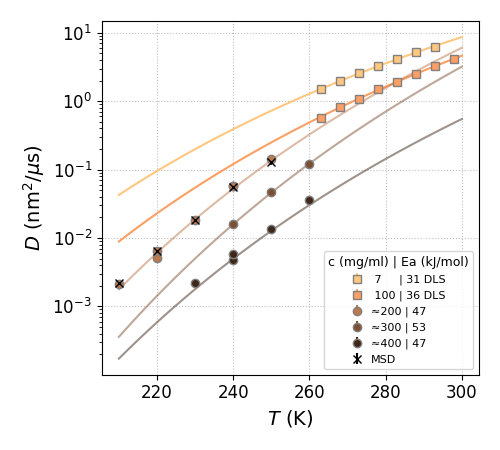

In [40]:
f, ax = plt.subplots(1,1, figsize=(5,4.5), tight_layout=True)
cols = plt.cm.copper_r(np.linspace(0,1,6))

Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
new_T = np.linspace(210,300,100)

# -- DLS
popt2,xc2,curve2,perr2 = fit(arrhenius, DLS['T'],  DLS['D'], sigma=DLS['dD'], p0=[1e6, -3e3])
Ea2, dEa2 = popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na
ax.plot(new_T, arrhenius(new_T, *popt2), ls='-', c=cols[0])#,label=f'7 mg/ml - DLS')# label=f'DLS: Ea={-Ea2:.0f} kJ/mol')# ± {dEa2:.0f} kJ/mol')
ax.errorbar(DLS['T'], DLS['D'], DLS['dD'], c=cols[0], ls='', marker='s', mec='gray',label=f' 7     | {-Ea2:.0f} DLS') # label='DLS dilute',

# -- new dls SU13_3
popt2,xc2,curve2,perr2 = fit(arrhenius, SU13_3['T'],  SU13_3['D'], sigma=SU13_3['dD'], p0=[1e6, -3e3])
Ea2, dEa2 = popt2[1] * Kbb / 1e3 * Na, perr2[1] * Kbb / 1e3 * Na
ax.plot(new_T, arrhenius(new_T, *popt2), ls='-', c=cols[1])#,label=f'7 mg/ml - DLS')# label=f'DLS: Ea={-Ea2:.0f} kJ/mol')# ± {dEa2:.0f} kJ/mol')
ax.errorbar(SU13_3['T'], SU13_3['D'], SU13_3['dD'], c=cols[1], ls='', marker='s', mec='gray',label=f' 100 | {-Ea2:.0f} DLS') # SU13_3

# -- 3 concentrations with arrhenius fit
labs = ['≈200', '≈300', '≈400']
# labs = ['≈100', '≈200', '≈350'] # very scheptical about this
for i, db in enumerate([D_c1,D_c2, D_c3]):
    # if i != 1:
    tem = np.array(db['temperature'])
    dif = db['D']
    ddif = db['dD']
    popt,xc,curve,perr = fit(arrhenius, tem, dif, sigma=ddif, p0=[15e4, -3e3])
    Ea, dEa = popt[1] * Kbb / 1e3 * Na, perr[1] * Kbb / 1e3 * Na

    new_T = np.linspace(210,300,100)
    # ax.plot(xc, curve, ls='-', c='C3',label=f'Ea = {Ea:.0f} ± {dEa:.0f} kJ/mol')
    ax.plot(new_T, arrhenius(new_T, *popt), ls='-', c=cols[i+2], alpha=0.5, )#label=f'{labs[i]} mg/ml')#label=f'{labs[i]}, Ea={-Ea:.0f} kJ/mol')
    ax.errorbar(db['temperature'],  db['D'], db['dD'], c=cols[i+2], ls='', marker='o', mec='gray',label=f'{labs[i]} | {-Ea:.0f}')#, label=labs[i])|

ax.errorbar(T_msd, D_msd[:,0], D_msd[:,1], marker='x', ls='', c='k', label='MSD')

# -- plot setting
ax.set_xlabel(f'$T$ (K)')
ax.set_ylabel('$D$ (nm$^{{2}}$/${{\mu}}$s)')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=8, handlelength=1, title='c (mg/ml) | Ea (kJ/mol)', title_fontsize=9) #, bbox_to_anchor=[1,1])
ax.set_yscale('log')
# plt.savefig('../06-figs/diff_coeff_arr2.png', dpi=900)

# Fig 3 - $\chi_4$

In [37]:
# select concentration
conc = 'c1'
qv = np.array([0.028, 0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.428, 0.468])

# load files and parameters
files = sorted(glob.glob(f"../03-source/chi4/chi4_{conc}*.npz"))
temps = np.unique([int(file[-14:-11]) for file in files])
inds = np.unique([int(file[-5:-4]) for file in files])

print(f"Temperatures available for {conc}: {temps}")


Temperatures available for c1: [210 220 230 240 250]


### q-dependence

Text(0.02, 0.9, 'b')

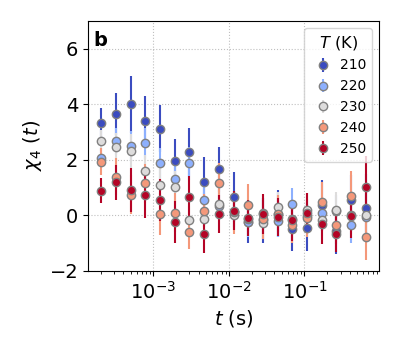

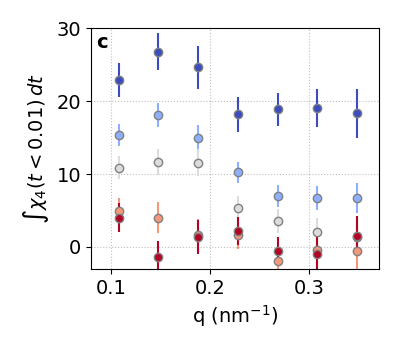

In [38]:
T_sel = temps[0]
q_int = 8
q_sel = 2

# f, (a1,a2) = plt.subplots(1,2,figsize=(11,4.5), tight_layout=True)
# f, a1 = plt.subplots(1,1,figsize=(4,3.5), tight_layout=True)
f3, a3 = plt.subplots(1,1,figsize=(4,3.5), tight_layout=True)
f2, a2 = plt.subplots(1,1,figsize=(4,3.5), tight_layout=True)

col = plt.cm.viridis(np.linspace(0,1,len(inds)))
col2 = plt.cm.coolwarm(np.linspace(0,1,len(temps)))

for j,T in enumerate(temps[:]):
    T_sel = temps[j]

    for i,ind in enumerate(inds):
        f = np.load(f"../03-source/chi4/chi4_{conc}_{T_sel}K_qind{ind}.npz")

        base = np.mean( f['chi4'][-10:])
        # if j == 0:
            # a1.errorbar(f['time'], f['chi4']-base, f['dchi4'], c=col[i], label=f'{qv[ind]:.2f}', ls='', marker='o', mec='gray')
        std_sum = np.sqrt(np.sum(f['dchi4'][:q_int]**2))
        # a2.errorbar(qv[ind], np.trapz(f['chi4'][:q_int]-base, f['time'][:q_int]), std_sum, ls='', c=col[i], marker='o', mec='gray')
        a2.errorbar(qv[ind], np.sum(f['chi4'][:q_int]-base), std_sum, ls='', c=col2[j], marker='o', mec='gray')
        
        if ind == q_sel:
            a3.errorbar(f['time'], f['chi4']-base, f['dchi4'], c=col2[j], label=f'{T:.0f}', ls='', marker='o', mec='gray')
    # a2.errorbar(qv[q_sel], np.sum(f['chi4'][:q_int]-base), std_sum, ls='', c=col2[j], marker='o', mec='gray')

# # a1.axvline(x=1e-2, ls='--', c='gray')
# a1.axvline(x=f['time'][q_int], ls='--', c='gray')

# a1.legend(title='q (nm$^{-1}$)', bbox_to_anchor=[1,1])
# a1.set_title(f'{conc}, T = {T_sel} K')
# a1.set_xscale('log')
# a1.set_xlabel('time (s)')
# a1.set_ylabel('$\chi_4$')

a2.set_xlim(0.08, 0.37)
a2.set_ylim(-3,30)
# a2.legend(temps[:-1], [])
a2.set_xlabel('q (nm$^{-1}$)')
a2.set_ylabel(f"$\int\chi_4(t<{f['time'][q_int]:.2f})\,dt$")
a2.text(0.02, 0.92, 'c', fontweight='bold', transform=a2.transAxes)

a3.set_xscale('log')
# a3.set_xlabel(f'$\tau (s)')
a3.legend(title='$T$ (K)', handletextpad=0.2, fontsize=10)
a3.set_xlabel(r"$t$ (s)")
a3.set_ylabel(r"$\chi_4$ ($t$)")
a3.set_ylim(-2,7)
a3.text(0.02, 0.9, 'b', fontweight='bold', transform=a3.transAxes)
# f3.savefig('../06-figs/chi4_time.png', dpi=300)
# f2.savefig('../06-figs/chi4_q.png', dpi=300)

### TTC

In [39]:
# ttcs_avg = np.mean(ttcs, axis=0)
ttcs_avg = np.load("../03-source/ttc-for-paper.npy")

In [40]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

/tmp/ipykernel_22686/3586272882.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), label='correlation', ticks=np.arange(vs[0],vs[1]+0.01,0.05))


Text(0.05, 0.92, 'a')

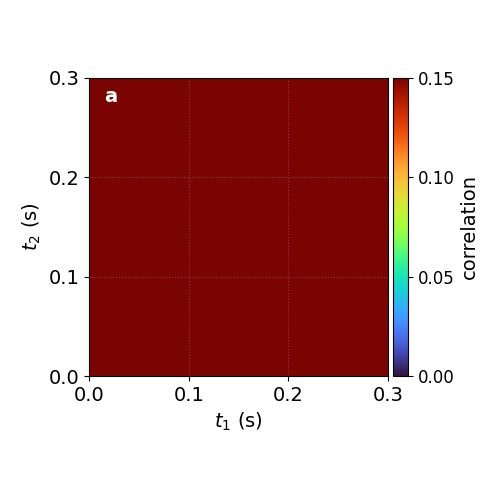

In [41]:
f, ax = plt.subplots(1,1, figsize=(5,5), tight_layout=True)
baseline = np.mean(ttcs_avg[:10,-10:])
# norm = len(ind_xpcs)
vs = [0., .15]

ax.imshow(ttcs_avg - baseline, origin='lower', cmap='turbo', 
        # extent=(time[0], time[-1])*2, 
        vmin=vs[0], vmax=vs[1], 
        # interpolation='gaussian'
        )

ax.set_xlabel('$t_1$ (s)')
ax.set_ylabel('$t_2$ (s)')
t_lim = 0.3
ax.set_xlim(0,t_lim)
ax.set_ylim(0,t_lim)
ax.set_xticks(np.arange(0,0.31,0.1))
ax.set_yticks(np.arange(0,0.31,0.1))
divider = make_axes_locatable(ax)
cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), label='correlation', ticks=np.arange(vs[0],vs[1]+0.01,0.05))
cb1.ax.tick_params(labelsize=12)
ax.text(0.05, 0.92, 'a', transform=ax.transAxes, color='w',  fontweight='bold',)
# ax.tick_params(axis='both', which='minor', labelsize=10)


### All panels together

In [33]:
from matplotlib import gridspec
import scipy as sp
import scipy.interpolate

NameError: name 'ind_xpcs' is not defined

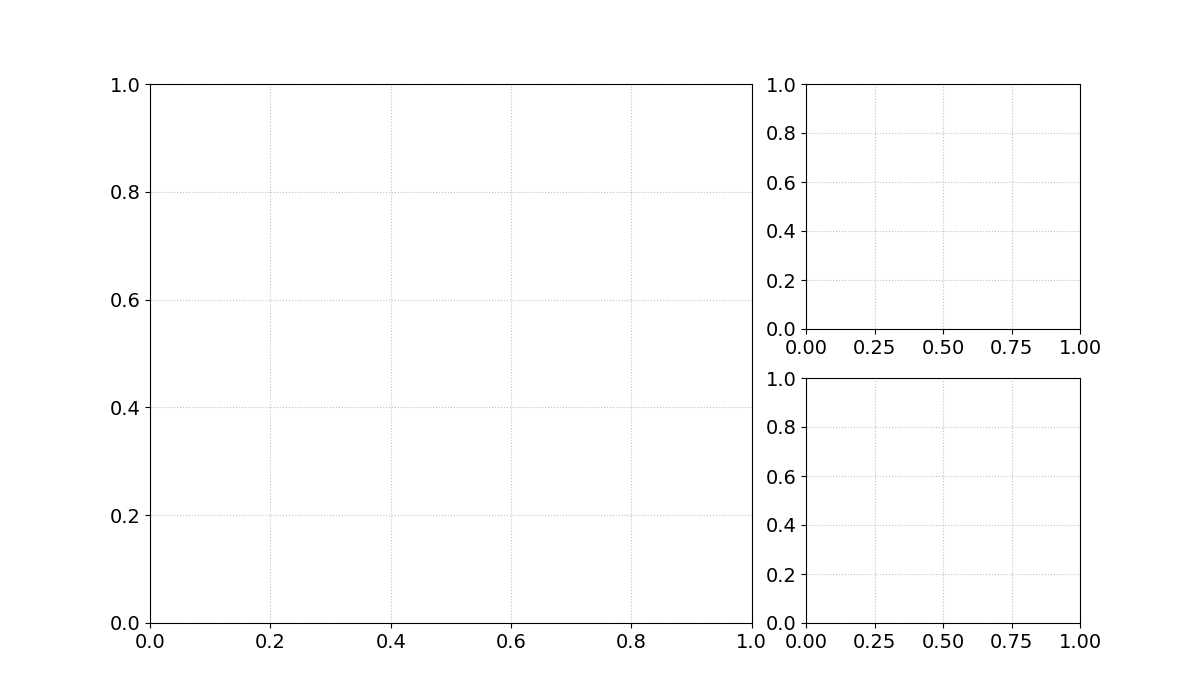

In [34]:
# creating grid for subplots
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(12)
 
ax1 = plt.subplot2grid(shape=(2, 3), loc=(0, 0), colspan=2, rowspan=2)
a3 = plt.subplot2grid(shape=(2, 3), loc=(0, 2), colspan=1)
a2 = plt.subplot2grid(shape=(2, 3), loc=(1, 2), rowspan=1) 
 
# -- PANEL A - TTC
baseline = np.mean(ttcs_avg[:10,-10:])
norm = len(ind_xpcs)
vs = [0., .15]
ax1.imshow(ttcs_avg - baseline, origin='lower', cmap='turbo', extent=(time[0], time[-1])*2, vmin=vs[0], vmax=vs[1], interpolation='bicubic')

ax1.set_xlabel('$t_1$ (s)')
ax1.set_ylabel('$t_2$ (s)')
t_lim = 0.3
ax1.set_xlim(0,t_lim)
ax1.set_ylim(0,t_lim)
ax1.set_xticks(np.arange(0,0.31,0.1))
ax1.set_yticks(np.arange(0,0.31,0.1))
divider = make_axes_locatable(ax1)
cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=vs[0],vmax=vs[1]), label='correlation', ticks=np.arange(vs[0],vs[1]+0.01,0.05))
cb1.ax.tick_params(labelsize=12)
ax1.text(0.05, 0.92, 'a', transform=ax1.transAxes, color='w',  fontweight='bold',)


# PANEL B - CHI4 VS TIME
# PANEL C - CHI4 VS Q
T_sel = temps[0]
q_int = 8
q_sel = 2
col = plt.cm.coolwarm(np.linspace(0,1,len(temps)))

for j,T in enumerate(temps[:]):
    T_sel = temps[j]

    for i,ind in enumerate(inds):
        f = np.load(f"../03-source/chi4/chi4_{conc}_{T_sel}K_qind{ind}.npz")

        base = np.mean( f['chi4'][-10:])
        std_sum = np.sqrt(np.sum(f['dchi4'][:q_int]**2))
        a2.errorbar(qv[ind], np.sum(f['chi4'][:q_int]-base), std_sum, ls='', c=col[j], marker='o', mec='gray')
        
        if ind == q_sel:
            # y_interp =  sp.interpolate.interp1d(f['time'], f['chi4']-base, kind='quadratic')
            # new_t = np.linspace(np.min(f['time']), np.max(f['time']), 1000)
            # a3.plot(new_t, y_interp(new_t), c=col[j], ls='-',  alpha=0.7)
            a3.errorbar(f['time'], f['chi4']-base, f['dchi4'], c=col[j], label=f'{T:.0f}', ls='', marker='o', mec='gray')

a2.set_xlim(0.08, 0.37)
a2.set_ylim(-3,30)
a2.set_xlabel('q (nm$^{-1}$)')
a2.set_ylabel(f"$\int\chi_4(t<{f['time'][q_int]:.2f})\,dt$")
a2.text(0.02, 0.92, 'c', fontweight='bold', transform=a2.transAxes)

a3.set_xscale('log')
a3.legend(title='$T$ (K)', handletextpad=0.2, fontsize=10)
a3.set_xlabel(r"$t$ (s)")
a3.set_ylabel(r"$\chi_4$ ($t$)")
a3.set_ylim(-2,7)
a3.text(0.02, 0.9, 'b', fontweight='bold', transform=a3.transAxes)
fig.tight_layout()
 

In [ ]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

    

In [ ]:
factor = 2
ttc_rebinned = rebin(ttcs_avg - baseline, (ttcs_avg.shape[0]//factor, ttcs_avg.shape[0]//factor))
np.shape(ttc_rebinned)

(2495, 2495)

/tmp/ipykernel_59362/4218303282.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(shrink=0.6, label='correlation')


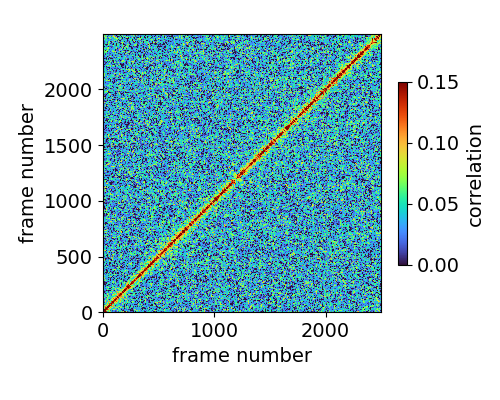

In [ ]:
plt.figure(figsize=(5,4))
plt.imshow(ttc_rebinned, origin='lower', vmin=0, vmax=.15, cmap='turbo')
plt.colorbar(shrink=0.6, label='correlation')
plt.xlabel('frame number')
plt.ylabel('frame number')
plt.tight_layout()

/tmp/ipykernel_59362/3091289778.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/tmp/ipykernel_59362/3091289778.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=0,vmax=vs[1]), label='correlation', ticks=np.arange(0,vs[1]+0.01,0.05))
/tmp/ipykernel_59362/3091289778.py:68: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first

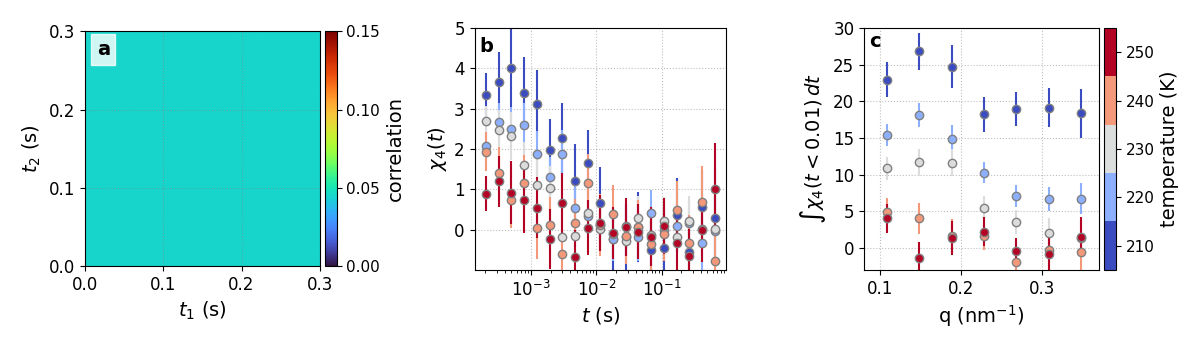

In [ ]:
# creating grid for subplots
fig = plt.figure()
fig.set_figheight(3.5)
fig.set_figwidth(12)
 
ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=1, rowspan=1)
a3 = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=1)
a2 = plt.subplot2grid(shape=(1, 3), loc=(0, 2), rowspan=1) 
 
# -- PANEL A - TTC
baseline = np.mean(ttcs_avg[:10,-10:])
# norm = len(ind_xpcs)
vs = [0.06, .15]
# ax1.imshow(ttcs_avg - baseline, origin='lower', cmap='turbo', extent=(time[0], time[-1])*2, vmin=vs[0], vmax=vs[1], interpolation='bicubic')
ax1.imshow(ttc_rebinned, origin='lower', cmap='turbo')#, vmin=vs[0], vmax=vs[1], interpolation='bicubic') # extent=(time[0], time[-1])*2,

ax1.set_xlabel('$t_1$ (s)')
ax1.set_ylabel('$t_2$ (s)')
t_lim = 0.2
ax1.set_xlim(0,t_lim)
ax1.set_ylim(0,t_lim)
ax1.set_xticks(np.arange(0,0.31,0.1))
ax1.set_yticks(np.arange(0,0.31,0.1))
divider = make_axes_locatable(ax1)
cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=mpl.cm.turbo,  orientation='vertical', norm=mpl.colors.Normalize(vmin=0,vmax=vs[1]), label='correlation', ticks=np.arange(0,vs[1]+0.01,0.05))
cb1.ax.tick_params(labelsize=11)
ax1.text(0.05, 0.9, 'a', transform=ax1.transAxes, color='k', fontweight='bold', bbox=dict(facecolor='w', edgecolor='w', alpha=0.8)) # fontweight='bold', fontsize=14,


# PANEL B - CHI4 VS TIME #### PANEL C - CHI4 VS Q
T_sel = temps[0]
q_int = 8
q_sel = 2
col = plt.cm.coolwarm(np.linspace(0,1,len(temps)))

for j,T in enumerate(temps[:]):
    T_sel = temps[j]

    for i,ind in enumerate(inds):
        f = np.load(f"../03-source/chi4/chi4_{conc}_{T_sel}K_qind{ind}.npz")

        base = np.mean( f['chi4'][-10:])
        std_sum = np.sqrt(np.sum(f['dchi4'][:q_int]**2))
        a2.errorbar(qv[ind], np.sum(f['chi4'][:q_int]-base), std_sum, ls='', c=col[j], marker='o', mec='gray')
        
        if ind == q_sel:
            a3.errorbar(f['time'], f['chi4']-base, f['dchi4'], c=col[j], label=f'{T:.0f}', ls='', marker='o', mec='gray')

a2.set_xlim(0.08, 0.37)
a2.set_ylim(-3,30)
a2.set_xlabel('q (nm$^{-1}$)')
# a2.set_ylabel(f"$\int\chi_4(tau <{f['time'][q_int]:.2f})\,dt$")
a2.set_ylabel(r"$\int\chi_4(t <0.01)\,dt$")
a2.text(0.02, 0.92, 'c', fontweight='bold', transform=a2.transAxes)

a3.set_xscale('log')
# a3.legend(title='$T$ (K)', handletextpad=0.2, fontsize=10)
a3.set_xlabel(r"$t$ (s)")
a3.set_ylabel(r"$\chi_4 (t)$")
a3.set_ylim(-1,5)
a3.set_yticks(np.arange(0,5.1,1))
a3.text(0.02, 0.9, 'b', fontweight='bold', transform=a3.transAxes)

# colorbar
bounds = [205, 215, 225, 235, 245, 255]
divider = make_axes_locatable(a2)
cmap = mpl.cm.coolwarm
cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=cmap,  orientation='vertical', norm=mpl.colors.BoundaryNorm(bounds, cmap.N), label='temperature (K)', ticks=np.arange(210,251,10))
cb1.ax.tick_params(labelsize=11)
# cb1 = mpl.colorbar.ColorbarBase(divider.append_axes('right', size='5%', pad=0.05), cmap=cmap,  orientation='vertical', norm=mpl.colors.BoundaryNorm(bounds, cmap.N), label='temperature (K)', ticks=np.arange(210,251,10))
# cb1.ax.tick_params(labelsize=11)

ax1.tick_params(axis='both', which='major', labelsize=12)
a2.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()
# fig.savefig('../06-figs/chi4_tttc.png', dpi=200)
 

# Beam damage

## Flux dependence

In [77]:
# c1 220 K fluxes
runnames = ['ferritin_conc_gly_50_5']
datasetnumbers = [4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_5', 'ferritin_conc_gly_50_5', 'ferritin_conc_gly_50_5']

In [78]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0004
Temperature, K       220.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0005.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0005
Temperature, K       220.0
transmission (%)     45
Absorbers 80um       1.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, 45% beam
Exposure time (s)    0.0004
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0006.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0006
Temper

In [79]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (3, 12, 80)


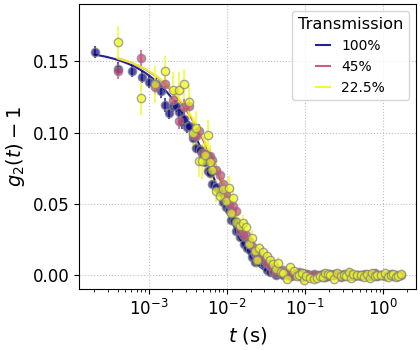

In [80]:
f, a1 = plt.subplots(1,1, figsize=(4.2,3.5), constrained_layout=True)

col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3

qv_min, qv_max, qstep = 2, len(qv)-2, 1
Tr_l = [100,45,22.5]

for i in range(len(datasetnumbers)):

    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        
        if q==qv_sel:
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i],ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{Tr_l[i]}%')

a1.legend(title='Transmission', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)
# a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
# a1.text(0.7, 0.4, 'T=220 K', fontsize=12, transform=a1.transAxes)

# plt.savefig('../06-figs/g2s_fluxes.png', dpi=300)

## Repetitions

In [ ]:
# c1 220 K full beam, repetitions
runname = 'ferritin_conc_gly_50_5'
datasetnumber = 4


In [60]:
filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

if os.path.isfile(filename):
    print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
    info = elog_selected_entries_dict(filename)
    
    for key in info.keys():
        print("{0:20} {1}".format(key, info[key]))

else:
    print(filename, "\nFile exists: False")


/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0006.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0006
Temperature, K       220.0
transmission (%)     ~22.5
Absorbers 80um       2.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, 22.5% beam
Exposure time (s)    0.0004
number of frames     5000.0


In [62]:
# filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

# rep = 0
nreps = 4

g2s = np.empty(shape=(nreps,len(qv),len(delay)))
dg2s = np.empty(shape=(nreps,len(qv),len(delay)))
# delays = np.empty(shape=(nreps, len(delay)))

# for i,(rep, runname) in enumerate(zip(datasetnumbers, runnames)):
# for i in range(nreps):
g2s[:,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[:,:,:]
dg2s[:,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[:,:,:]
    # delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (4, 12, 80)


4
0
1
2
3


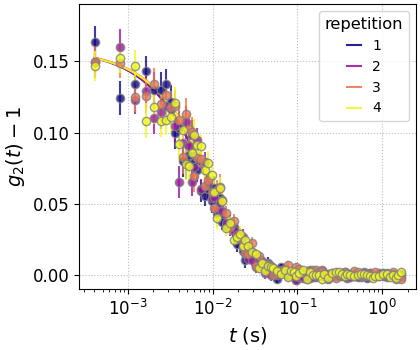

In [75]:
f, a1 = plt.subplots(1,1, figsize=(4.2,3.5), constrained_layout=True)

col = plt.cm.plasma(np.linspace(0,1,nreps))
qv_sel = 2
tol = 1e-3

qv_min, qv_max, qstep = 2, len(qv)-2, 1
reps = np.arange(1,5,1)

print(len(col))
for i in range(nreps):
    print(i)
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        
        if q==qv_sel:
            popt,xc,curve,perr = fit(exponential, delay, g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
            a1.errorbar(delay, g2s[i,q,:]-base, dg2s[i,q,:], c=col[i],ls='', marker='o', ms=6, mec='gray', alpha=0.8)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=reps[i])

a1.legend(title='repetition', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(t)-1$')
a1.set_yticks(np.arange(0,0.16,0.05))
a1.set_ylim(-0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)
# a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
# a1.text(0.7, 0.4, 'T=220 K', fontsize=12, transform=a1.transAxes)

# plt.savefig('../06-figs/g2s_reps.png', dpi=300)